In [174]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import itertools
from scipy.signal import savgol_filter
import matplotlib.image as mpimg
from scipy.ndimage import gaussian_filter, laplace
from scipy import ndimage
#import cv2
from scipy import interpolate
from mpl_toolkits import mplot3d
from PIL import Image
%matplotlib inline
import IPython
import pickle
# from vtk.util import numpy_support
# import vtk
import pyvista as pv
import numpy as np
from scipy.interpolate import interpn
import plotly.graph_objects as go

#  Real time formation evaluation

01.12.2022

## 3D synthetic dataset of LWD Resistivity

## Initial JPG with 2D LWD Resistivity Profile
- | -
- | - 
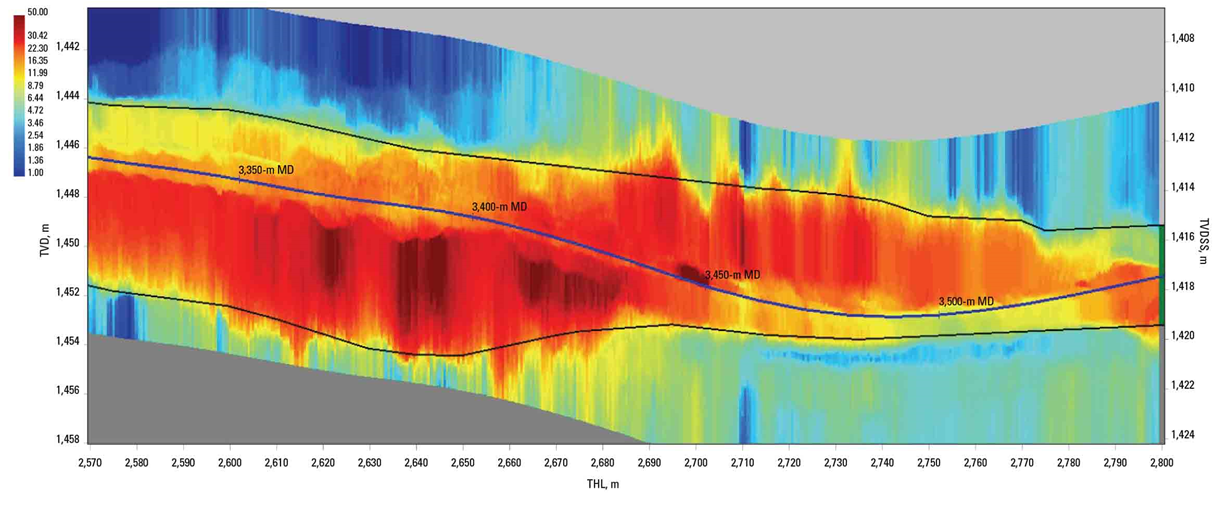 | 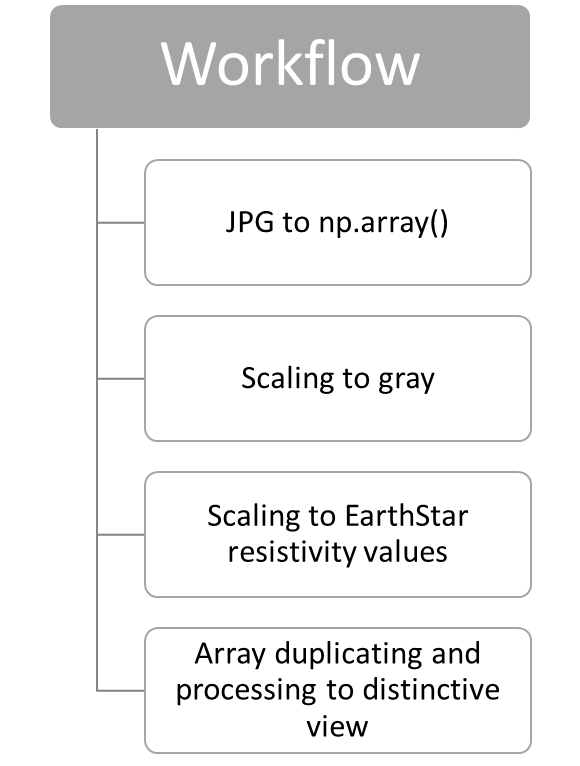


## From Multi 2d to 3D dataset


<div>
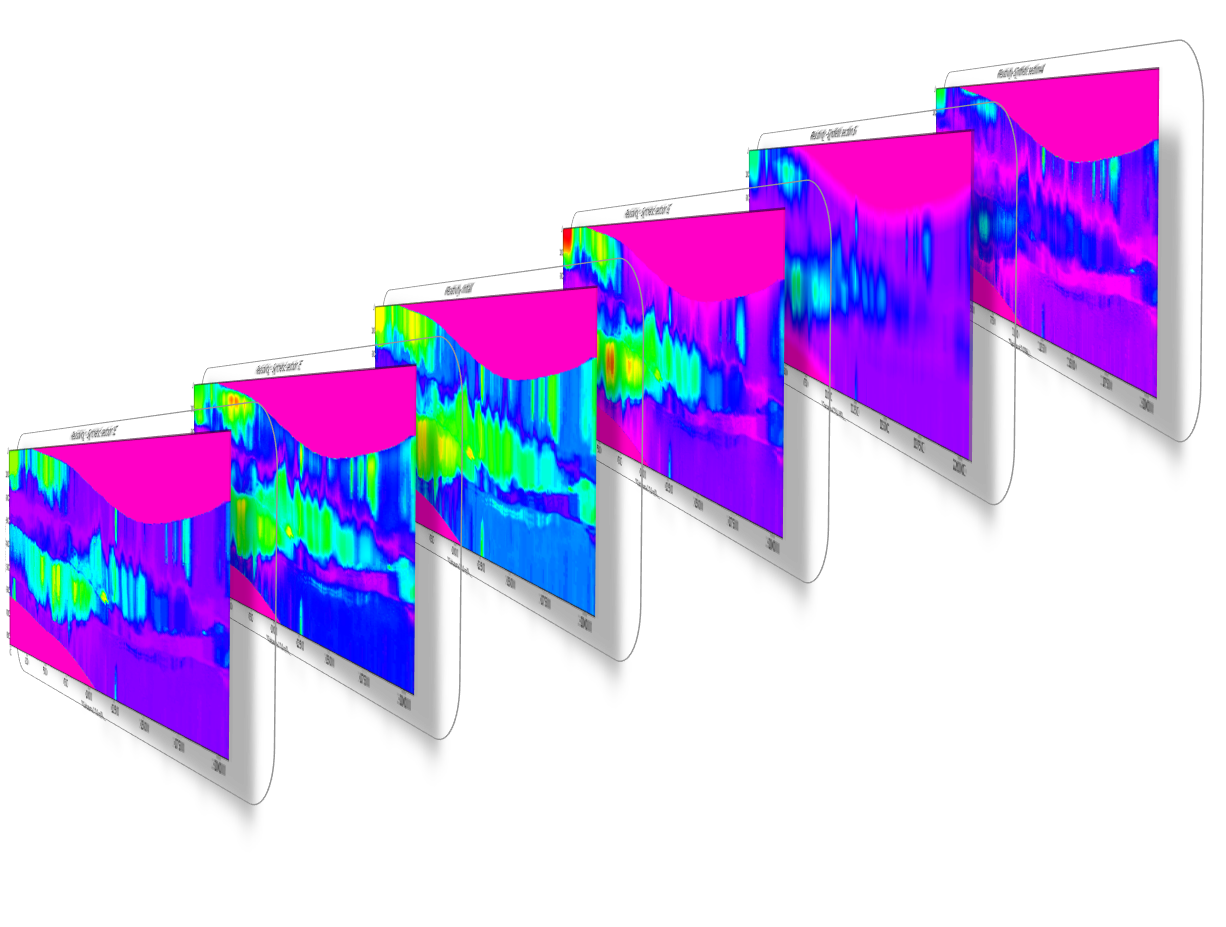
</div>


<div>
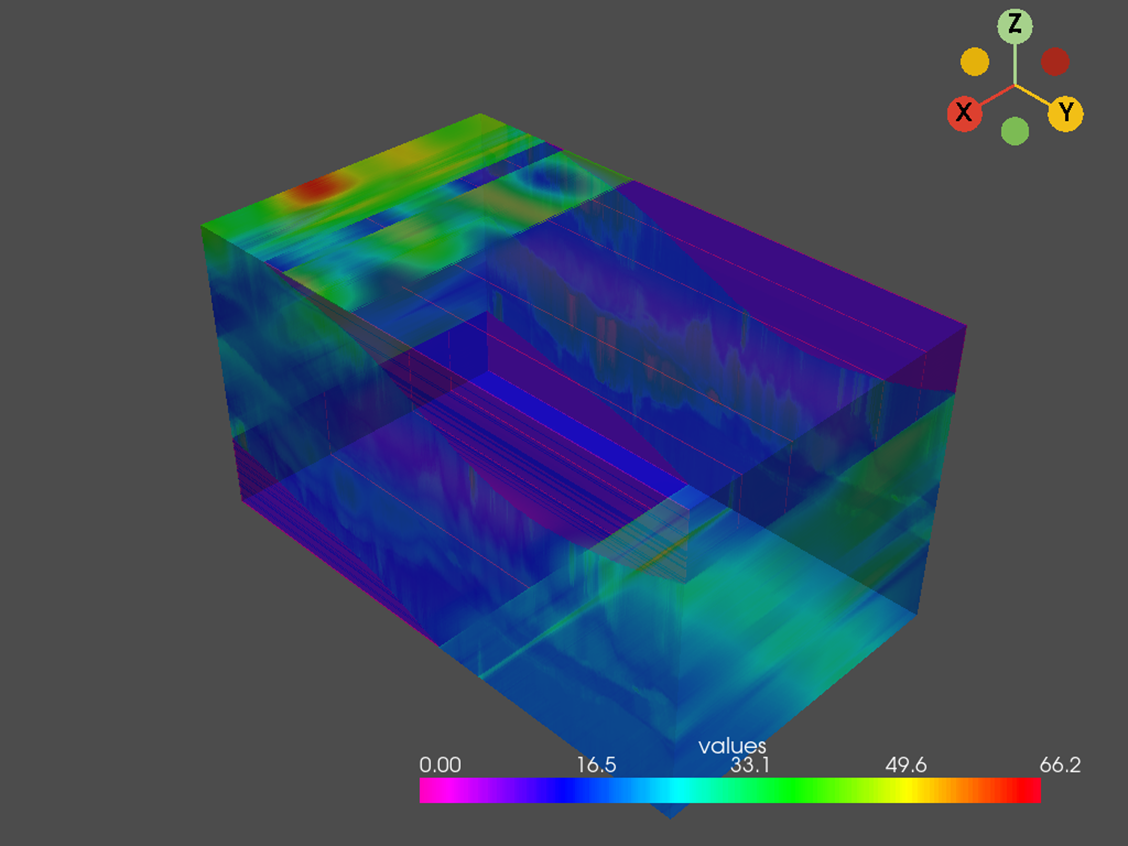
</div>

# 3D real-time geosteering based on greedy algorithm

###  <center> Objective function  </center>
$$ \large g_f(N(x_i)) = \frac{\sum_{i=0}^{n}  \int_{x_i}^{x_{i+n_s}} f(x)dx}{\sum_{i=0}^{n}||x_{i+{n_s} - x_i } ||}$$

$$ \large x_{i+1} = x_{i} +l \cdot sin(\theta_i)cos(\phi_i) $$
$$ \large y_{i+1} = y_{i} +l \cdot sin(\theta_i)sin(\phi_i) $$
$$ \large z_{i+1} = z_{i} +l \cdot sin(\theta_i) $$
<font size="3"> <b> where: $ \theta $ - zenith angle, $\phi $ - azimuth  <b>
    
<font size="3"> <b> Dogleg constraint <b>
$$ \large DLS = {cos^{-1}}[(cos \theta_1 \cdot cos \theta_2) + (sin \theta_1 \cdot sin \theta_2) \cdot cos(\phi_2 - \phi_1)]\cdot \frac{100}{CL} $$
    
    
* Kristoffersen, Bellout,Silva, Berg. An Automatic Well Planner for Complex Well Trajectories. Mathematical Geosciences. 2021. https://doi.org/10.1007/s11004-021-09953-x


* Lyu, Lei, Yanh, Heaney, Song. A novel approach to optimising well trajectory in heterogeneous reservoirs based on the fast-marching method. Journal of Natural Gas Science and Engineering 88. 2021. https://doi.org/10.1016/j.jngse.2021.103853



In [187]:
# import 3d cube
#file = open("./RL/3D_301.833.2055.pickle",'rb')
file = open("./RL/3D_80.80.230.pickle",'rb')
cube_3d = pickle.load(file)

In [196]:
volume_cut= cube_3d[::1,::1,::1]
# volume_cut = np.einsum('abc->acb', volume_cut)
volume_cut.shape

(80, 80, 230)

In [197]:
def plot(traj_x,traj_y, traj_z, animation = True):
    fig = go.Figure()

    fig.add_trace(
        go.Scatter3d(
            x=traj_x,
            y=traj_z,
            z=traj_y,
            mode='lines',
            line=dict(
                color='red',
                width = 7
            ),
            name='survey_interpolated'
        ),
    )
    fig.update_layout(scene = dict(
                  #  xaxis_title='X AXIS TITLE',
                    yaxis_title='Drilling direction',
                    zaxis_title='True vertical depth (TVD)'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

    fig.update_scenes(zaxis_autorange="reversed")
    fig.show()
    


Inputs:
- start point (x,y,z) coordinate
- initial azimuth angle
- initial zenith angle
- azimuth constraints
- zenith constraints
- dogleg constraint
- length of 1 step
- steps ahead of productivity calculation


In [198]:
from vol_greedy_polar_coordinates import greedy_geosteering_polar
from cartesian_gredy import greedy_geosteering_advanced, Greedy_3d

In [199]:
# steps ahead 4 = 404.61

In [201]:
greedy_1 = greedy_geosteering_polar(volume_cut, length = 1, steps_ahead = 3,
    start_point = [20,20,100], init_inclination = 88, init_azimut = 0, angle_constraint_per_m=0.1,
    min_azimut=-20, max_azimut = 20, min_zenith=70, max_zenith=92,
    step_incl = 1, step_azi = 1)
traj_x, traj_y, traj_z = greedy_1.traj_planning()

87 1 [ 20.01742849  20.99847744 100.05233596]
87 1 [ 20.03485698  21.99695488 100.10467191]
86 2 [ 20.06967146  22.99391124 100.17442839]
86 2 [ 20.10448594  23.9908676  100.24418486]
87 1 [ 20.12191443  24.98934504 100.29652082]
87 1 [ 20.13934292  25.98782248 100.34885677]
86 2 [ 20.1741574   26.98477884 100.41861325]
86 2 [ 20.20897189  27.9817352  100.48836972]
85 3 [ 20.26110869  28.97656465 100.57552546]
85 3 [ 20.31324549  29.9713941  100.66268121]
84 4 [ 20.38261983  30.96349339 100.76720967]
84 4 [ 20.45199417  31.95559268 100.87173813]
85 3 [ 20.50413097  32.95042212 100.95889387]
85 3 [ 20.55626778  33.94525157 101.04604962]
86 2 [ 20.59108226  34.94220793 101.11580609]
86 2 [ 20.62589674  35.93916429 101.18556256]
85 3 [ 20.67803355  36.93399374 101.27271831]
85 3 [ 20.73017035  37.92882319 101.35987405]
84 4 [ 20.79954469  38.92092248 101.46440251]
84 4 [ 20.86891903  39.91302177 101.56893098]
85 3 [ 20.92105583  40.90785122 101.65608672]
85 3 [ 20.97319263  41.90268066 10

In [202]:
def plot_results(volume_cube, traj_x, traj_y, traj_z, along_axis = 'y'):

    x = []
    z = []
    y = []
    property_along_y = []
    property_along_x = []
    property_along_z = []
    for i in range(0,len(traj_x)):
        x.append(traj_x[i])
        z.append(traj_z[i])
        y.append(traj_y[i])
        property_along_y.append(volume_cube[round(traj_x[i]),:,round(traj_z[i])].T)
        property_along_x.append(volume_cube[:,round(traj_y[i]),round(traj_z[i])].T)
        property_along_z.append(volume_cube[round(traj_x[i]),round(traj_y[i]),:].T)


    x_t = np.array(x)
    z_t = np.array(z)
    y_t = np.array(y)
    
    fig, ax = plt.subplots(1,1, figsize = (15,10))
    property_along_y_arr = np.array(property_along_y)
    property_along_x_arr = np.array(property_along_x)
    property_along_z_arr = np.array(property_along_z)
  #  ax.plot(z_t, color = 'r', linewidth = 3 )
    ax.set_title('XZ trajectory projection')

    #ax.imshow(property_along_z_arr.T[::-1])
    if along_axis == 'y':
        p_map = ax.imshow(property_along_y_arr, aspect='auto')
        ax.plot(y_t, color = 'r', linewidth = 3 )
    elif along_axis == 'z':
        p_map = ax.imshow(property_along_z_arr.T[::-1], aspect='auto')
        ax.plot(z_t, color = 'r', linewidth = 3 )
    else:
        p_map = ax.imshow(property_along_x_arr, aspect='auto')
        ax.plot(x_t, color = 'r', linewidth = 3 )
    plt.colorbar(p_map)

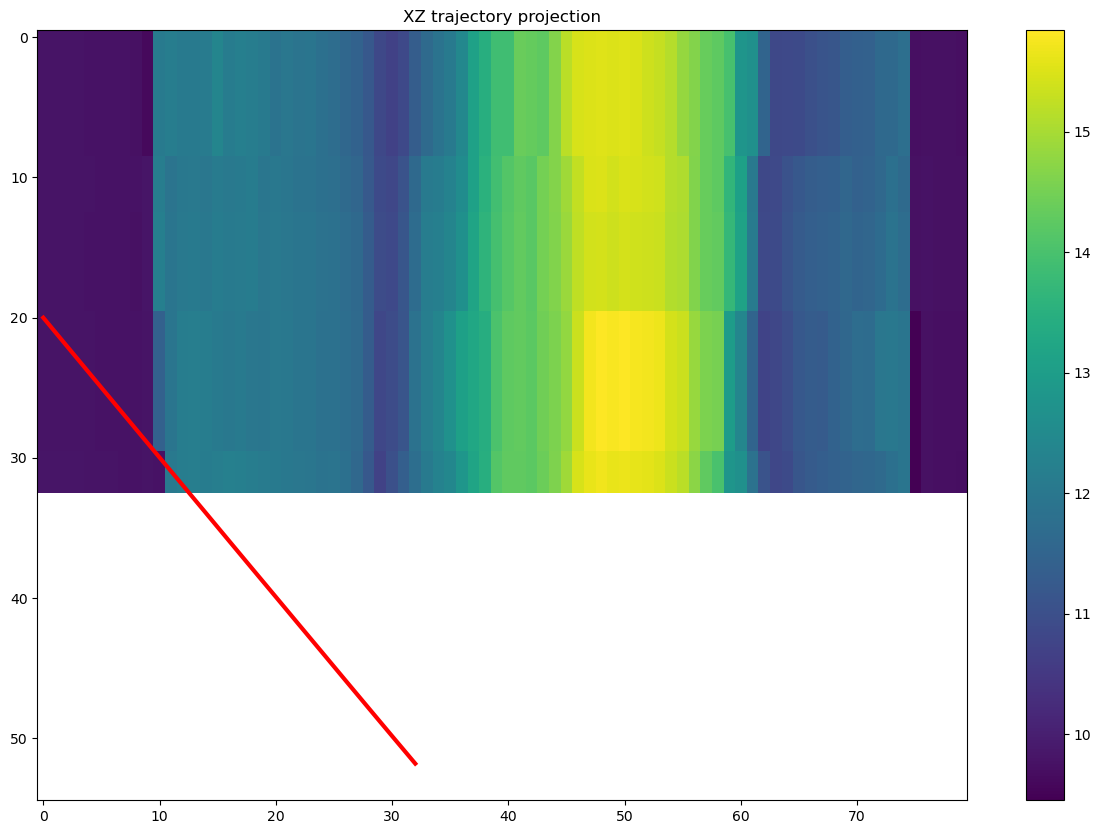

In [207]:
plot_results(volume_cut, traj_x, traj_y, traj_z, along_axis = 'y')

In [183]:
traj_x_2 =  [traj_x[0],  traj_x[-1]]
traj_y_2 =  [traj_y[0], traj_y[-1]]
traj_z_2 =  [traj_z[0], traj_z[-1]]

In [184]:

x = []
z = []
y = []
property_along_y = []
property_along_x = []
property_along_z = []
for i in range(0,len(traj_x)):
    x.append(traj_x[i])
    z.append(traj_z[i])
    y.append(traj_y[i])
    property_along_y.append(volume_cut[round(traj_x[i]),:,round(traj_z[i])].T)
    property_along_x.append(volume_cut[:,round(traj_y[i]),round(traj_z[i])].T)
    property_along_z.append(volume_cut[round(traj_x[i]),round(traj_y[i]),:].T)


x_t = np.array(x)
z_t = np.array(z)
y_t = np.array(y)

property_along_y_arr = np.array(property_along_y)
property_along_x_arr = np.array(property_along_x)
property_along_z_arr = np.array(property_along_z)

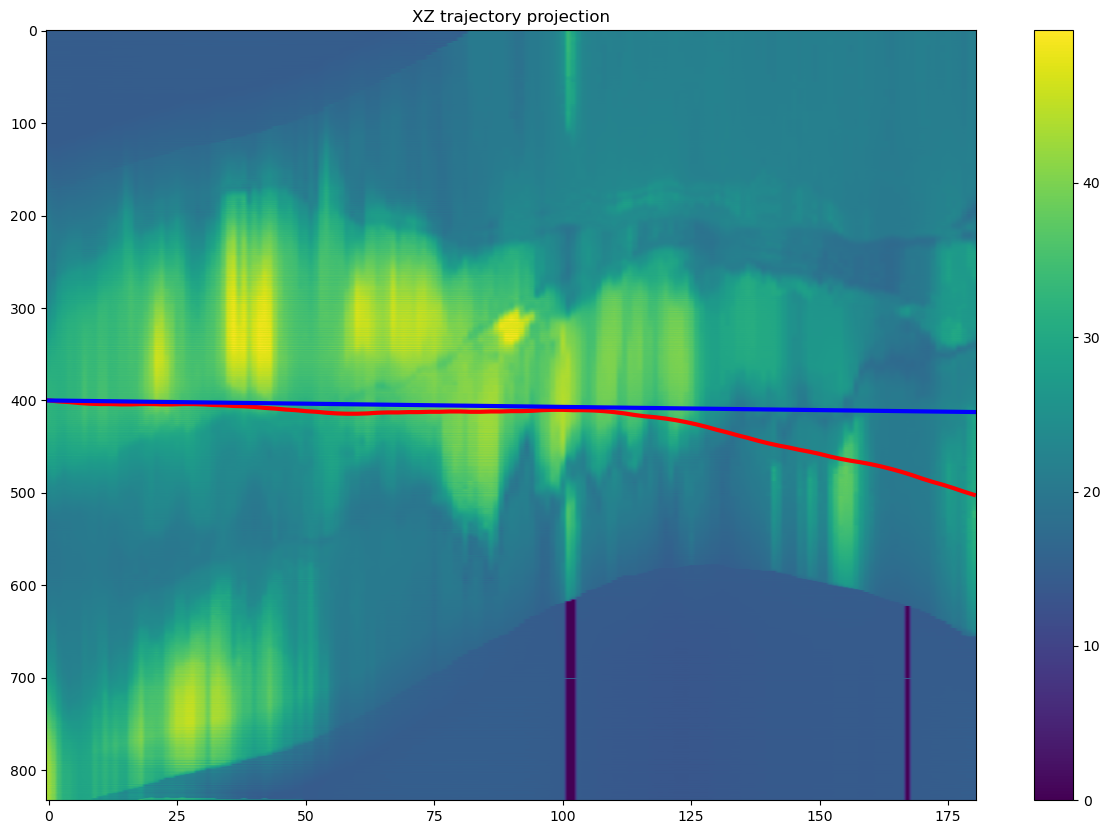

In [185]:
fig, ax = plt.subplots(1,1, figsize = (15,10))
ax.plot(z_t, color = 'r', linewidth = 3 )
ax.set_title('XZ trajectory projection')
ax.plot([0,1471],traj_z_2, color = 'b', linewidth = 3 )
p_map = ax.imshow(property_along_z_arr.T[::-1], aspect='auto')
plt.colorbar(p_map)

# Polar coordinates greedy algorithm

In [186]:
plot(traj_x,traj_y,traj_z)

# Reinforcement learning approach


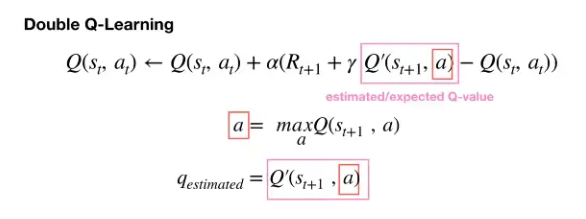

# Double Deep Q-network

Double DQN uses two different Deep Neural Networks, Deep Q Network (DQN) and Target Network
<b>   Q function in state t action t


    
Q function is for selecting the best action a with maximum Q-value of next state.
$$ \large a = max_a Q(s_{t+1}, a) $$
    
Q' function is for calculating expected Q-value by using the action a selected above.
$$ \large q_{estimated} = Q'(s_{t+1}, a) $$

Update Q function for state $s_t$ in action $a_t$ by using the expected Q-value of Q’ function
$$ \large Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha (R_{t+1} + \gamma Q'(s_{t+1},a) - Q(s_t, a_t))    $$

## Deep Q-network = Target Network

## Q-network architecture
<div>
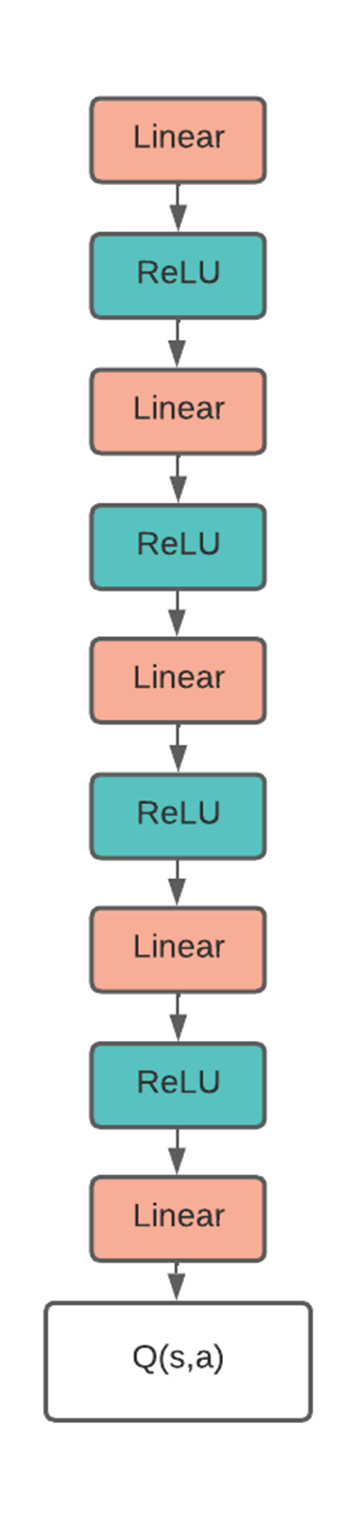
</div>

<b> Huber loss </b> function (for optimization of network weights)

<b> Huber loss </b>  is useful if your observed rewards are corrupted occasionally (i.e. you erroneously receive unrealistically huge negative/positive rewards in your training environment, but not your testing environment). Your estimate of E[R|s, a] will get completely thrown off by your corrupted training data if you use L2 loss. Huber loss, however, is much more robust to the presence of outliers.
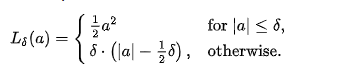

<b> Goal is to find the optimal trajectory along the environment

<b> Reward function:
    
- Productivity reward for each step
    
- Penalty for getting out of volume space/pay zone

- Penalty for exceeded dogleg angle

</b>

## Environment hyperparameters:
- Initial azimuth
- Initial zenith
- type of initial state (random or fixed)
- if initial state is fixed $ \rightarrow $ initialize start point
- angle constraint
- inclination step
- azimiuth step

## RL agent hyperparameters:
- gamma/learning rate of Q-net
- number of states
- number of actions
- memory size
- epsilon (stochasticity of action choice)
- epsilon decay

# 